<a href="https://colab.research.google.com/github/ohallao/MoneyBall-Brasileirao/blob/main/Performance_times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install adjustText
!pip install fuzzywuzzy
!pip install soccerdata

In [2]:
import soccerdata as sd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import unidecode
import seaborn as sns
from sklearn.linear_model import LinearRegression
from fuzzywuzzy import process
from adjustText import adjust_text

[01/06/25 04:21:19] INFO     No custom team name replacements found. You can configure these in       ]8;id=402901;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=73039;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py#90\90]8;;\
                             /root/soccerdata/config/teamname_replacements.json.                                   

                    INFO     Custom league dict loaded from                                          ]8;id=25484;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=872829;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py#194\194]8;;\
                             /root/soccerdata/config/league_dict.json.                                             

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 2. Obtenção dos Dados

In [3]:
sd.FBref.available_leagues()
fbref = sd.FBref(leagues="BRA-Serie A", seasons=2024)
print(fbref.__doc__)

[01/06/25 04:21:20] INFO     Saving cached data to /root/soccerdata/data/FBref                       ]8;id=980052;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=564235;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

Provides pd.DataFrames from data at http://fbref.com.

    Data will be downloaded as necessary and cached locally in
    ``~/soccerdata/data/FBref``.

    Parameters
    ----------
    leagues : string or iterable, optional
        IDs of leagues to include. For efficiently reading data from the Top-5
        European leagues, use "Big 5 European Leagues Combined".
    seasons : string, int or list, optional
        Seasons to include. Supports multiple formats.
        Examples: '16-17'; 2016; '2016-17'; [14, 15, 16]
    proxy : 'tor' or dict or list(dict) or callable, optional
        Use a proxy to hide your IP address. Valid options are:
            - "tor": Uses the Tor network. Tor should be running in
              the background on port 9050.
            - dict: A dictionary with the proxy to use. The dict should be
              a mapping of supported protocols to proxy addresses. For example::

                  {
                      'http': 'http://10.10.1.10:3128',
     

In [4]:
team_season_std = fbref.read_team_season_stats(stat_type="standard")
team_season_std.head()

/usr/local/lib/python3.10/dist-packages/soccerdata/fbref.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(dfs)
/usr/local/lib/python3.10/dist-packages/soccerdata/_common.py:145: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


players_used   Age  Poss Playing Time  \
                                                                       MP   
league      season team                                                     
BRA-Serie A 2425   Ath Paranaense             31  26.2  46.9           38   
                   Atl Goianiense             40  26.5  47.4           38   
                   Atlético Mineiro           36  28.1  57.2           38   
                   Bahia                      30  27.7  55.8           38   
                   Botafogo (RJ)              38  27.9  53.8           38   

                                                     Performance          ...  \
                                    Starts   Min 90s         Gls Ast G+A  ...   
league      season team                                                   ...   
BRA-Serie A 2425   Ath Paranaense      418  3420  38          39  35  74  ...   
                   Atl Goianiense      418  3420  38          28  16  44  ...   
                   Atlético Mineiro    418  3420  38          47  23  70  ...   
                   Bahia               418  3420  38          49  40  89  ...   
                   Botafogo (RJ)       418  3420  38          58  41  99  ...   

                                    Per 90 Minutes                           \
                                               Ast   G+A  G-PK G+A-PK    xG   
league      season team                                                       
BRA-Serie A 2425   Ath Paranaense             0.92  1.95   1.0   1.92  1.24   
                   Atl Goianiense             0.42  1.16  0.66   1.08  1.07   
                   Atlético Mineiro           0.61  1.84  0.95   1.55  1.21   
                   Bahia                      1.05  2.34  1.24   2.29  1.35   
                   Botafogo (RJ)              1.08  2.61  1.42    2.5  1.51   

                                                                 \
                                      xAG xG+xAG  npxG npxG+xAG   
league      season team                                           
BRA-Serie A 2425   Ath Paranaense    0.99   2.23   1.2     2.19   
                   Atl Goianiense    0.72   1.79  0.96     1.68   
                   Atlético Mineiro  0.68    1.9  0.94     1.63   
                   Bahia             1.07   2.42  1.31     2.38   
                   Botafogo (RJ)     1.08   2.59  1.39     2.47   

                                                                                url  
                                                                                     
league      season team                                                              
BRA-Serie A 2425   Ath Paranaense    /en/squads/2091c619/Athletico-Paranaense-Stats  
                   Atl Goianiense     /en/squads/32d508ca/Atletico-Goianiense-Stats  
                   Atlético Mineiro      /en/squads/422bb734/Atletico-Mineiro-Stats  
                   Bahia                            /en/squads/157b7fee/Bahia-Stats  
                   Botafogo (RJ)              /en/squads/d9fdd9d9/Botafogo-RJ-Stats  

[5 rows x 32 columns]

In [5]:
sofascore = sd.Sofascore(leagues='BRA-Serie A', seasons='24')
print(sofascore.__doc__)

[01/06/25 04:21:21] INFO     Saving cached data to /root/soccerdata/data/Sofascore                   ]8;id=299683;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=936709;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

Provides pd.DataFrames from data available at http://www.sofascore.com.

    Data will be downloaded as necessary and cached locally in
    ``~/soccerdata/data/Sofascore``.

    Parameters
    ----------
    leagues : string or iterable, optional
        IDs of Leagues to include.
    seasons : string, int or list, optional
        Seasons to include. Supports multiple formats.
        Examples: '16-17'; 2016; '2016-17'; [14, 15, 16]
    proxy : 'tor' or dict or list(dict) or callable, optional
        Use a proxy to hide your IP address. Valid options are:
            - 'tor': Uses the Tor network. Tor should be running in
              the background on port 9050.
            - dict: A dictionary with the proxy to use. The dict should be
              a mapping of supported protocols to proxy addresses. For example::

                  {
                      'http': 'http://10.10.1.10:3128',
                      'https': 'http://10.10.1.10:1080',
                  }

            - 

In [14]:
league_table = sofascore.read_league_table()
league_table.head()

/usr/local/lib/python3.10/dist-packages/soccerdata/_common.py:145: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


team  MP   W   D  L  GF  GA  GD  Pts
league      season                                               
BRA-Serie A 2425         Botafogo  38  23  10  5  59  29  30   79
            2425        Palmeiras  38  22   7  9  60  33  27   73
            2425         Flamengo  38  20  10  8  61  42  19   70
            2425        Fortaleza  38  19  11  8  53  39  14   68
            2425    Internacional  38  18  11  9  53  36  17   65

In [7]:
def get_market_values(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36'
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Verifica se houve erro na requisição
    except requests.exceptions.RequestException as e:
        print(f"Erro na requisição: {e}")
        return pd.DataFrame()  # Retorna DataFrame vazio em caso de erro

    soup = BeautifulSoup(response.content, 'html.parser')

    # Listas para armazenar os dados
    clubes = []
    valores = []

    # Encontrar a tabela com os clubes e valores de mercado
    table = soup.find('table', {'class': 'items'})

    if not table:
        print("Tabela não encontrada.")
        return pd.DataFrame()  # Retorna DataFrame vazio se a tabela não for encontrada

    # Extrair nome do clube e valor de mercado
    rows = table.find_all('tr', {'class': ['odd', 'even']})
    for row in rows:
        try:
            clube = row.find('td', {'class': 'hauptlink'}).text.strip()
            valor = row.find_all('td', {'class': 'rechts'})[1].text.strip()

            # Tratamento do valor de mercado
            valor = valor.lower().replace('€', '').replace('mi', '').replace('.', '').replace(',', '.').strip()
            valor_float = float(valor)  # Escala para milhões

            clubes.append(clube)
            valores.append(valor_float)
        except (AttributeError, IndexError, ValueError) as e:
            print(f"Erro ao processar a linha: {e}")
            continue  # Ignora a linha em caso de erro e continua o scraping

        # Adicionar delay para evitar bloqueios (entre 3 e 6 segundos)
        time.sleep(random.uniform(3, 6))

    # Retornar os dados como DataFrame
    df = pd.DataFrame({'Clube': clubes, 'Valor de Mercado (€)': valores})
    return df

# URL da página da Série A no Transfermarkt
url = 'https://www.transfermarkt.com.br/campeonato-brasileiro-serie-a/startseite/wettbewerb/BRA1'

# Executar a função e exibir os dados
df_clubes = get_market_values(url)
print(df_clubes)

               Clube  Valor de Mercado (€)
0       SE Palmeiras                236.68
1        CR Flamengo                216.95
2        Botafogo FR                161.90
3     SC Corinthians                108.20
4       São Paulo FC                 97.65
5   SC Internacional                 89.15
6        Cruzeiro EC                 88.45
7   Atlético Mineiro                 86.70
8      RB Bragantino                 81.20
9   CR Vasco da Gama                 79.70
10       Grêmio FBPA                 78.30
11     Fluminense FC                 77.45
12          EC Bahia                 76.70
13      Fortaleza EC                 54.45
14         Santos FC                 52.60
15        EC Vitória                 24.33
16          Ceará SC                 21.00
17      EC Juventude                 13.43
18      Sport Recife                 12.60
19       Mirassol FC                 10.23


# 3. Exploração e Limpeza de Dados

In [8]:
team_season_std = team_season_std.reset_index()
print(team_season_std.columns)
team_season_std.head()

MultiIndex([(        'league',         ''),
            (        'season',         ''),
            (          'team',         ''),
            (  'players_used',         ''),
            (           'Age',         ''),
            (          'Poss',         ''),
            (  'Playing Time',       'MP'),
            (  'Playing Time',   'Starts'),
            (  'Playing Time',      'Min'),
            (  'Playing Time',      '90s'),
            (   'Performance',      'Gls'),
            (   'Performance',      'Ast'),
            (   'Performance',      'G+A'),
            (   'Performance',     'G-PK'),
            (   'Performance',       'PK'),
            (   'Performance',    'PKatt'),
            (   'Performance',     'CrdY'),
            (   'Performance',     'CrdR'),
            (      'Expected',       'xG'),
            (      'Expected',     'npxG'),
            (      'Expected',      'xAG'),
            (      'Expected', 'npxG+xAG'),
            (   'Progression',  

league season              team players_used   Age  Poss Playing Time  \
                                                                           MP   
0  BRA-Serie A   2425    Ath Paranaense           31  26.2  46.9           38   
1  BRA-Serie A   2425    Atl Goianiense           40  26.5  47.4           38   
2  BRA-Serie A   2425  Atlético Mineiro           36  28.1  57.2           38   
3  BRA-Serie A   2425             Bahia           30  27.7  55.8           38   
4  BRA-Serie A   2425     Botafogo (RJ)           38  27.9  53.8           38   

                    ... Per 90 Minutes                                        \
  Starts   Min 90s  ...            Ast   G+A  G-PK G+A-PK    xG   xAG xG+xAG   
0    418  3420  38  ...           0.92  1.95   1.0   1.92  1.24  0.99   2.23   
1    418  3420  38  ...           0.42  1.16  0.66   1.08  1.07  0.72   1.79   
2    418  3420  38  ...           0.61  1.84  0.95   1.55  1.21  0.68    1.9   
3    418  3420  38  ...           1.05  2.34  1.24   2.29  1.35  1.07   2.42   
4    418  3420  38  ...           1.08  2.61  1.42    2.5  1.51  1.08   2.59   

                                                             url  
   npxG npxG+xAG                                                  
0   1.2     2.19  /en/squads/2091c619/Athletico-Paranaense-Stats  
1  0.96     1.68   /en/squads/32d508ca/Atletico-Goianiense-Stats  
2  0.94     1.63      /en/squads/422bb734/Atletico-Mineiro-Stats  
3  1.31     2.38                 /en/squads/157b7fee/Bahia-Stats  
4  1.39     2.47           /en/squads/d9fdd9d9/Botafogo-RJ-Stats  

[5 rows x 35 columns]

In [9]:
# 1. Achatar o MultiIndex para facilitar a manipulação
team_season_std.columns = ['_'.join(col).strip() for col in team_season_std.columns]

# 2. Verificar os novos nomes das colunas
print(team_season_std.columns)


Index(['league_', 'season_', 'team_', 'players_used_', 'Age_', 'Poss_',
       'Playing Time_MP', 'Playing Time_Starts', 'Playing Time_Min',
       'Playing Time_90s', 'Performance_Gls', 'Performance_Ast',
       'Performance_G+A', 'Performance_G-PK', 'Performance_PK',
       'Performance_PKatt', 'Performance_CrdY', 'Performance_CrdR',
       'Expected_xG', 'Expected_npxG', 'Expected_xAG', 'Expected_npxG+xAG',
       'Progression_PrgC', 'Progression_PrgP', 'Per 90 Minutes_Gls',
       'Per 90 Minutes_Ast', 'Per 90 Minutes_G+A', 'Per 90 Minutes_G-PK',
       'Per 90 Minutes_G+A-PK', 'Per 90 Minutes_xG', 'Per 90 Minutes_xAG',
       'Per 90 Minutes_xG+xAG', 'Per 90 Minutes_npxG',
       'Per 90 Minutes_npxG+xAG', 'url_'],
      dtype='object')


In [10]:
# Verificar os Nomes dos Clubes
df_teams = league_table
print("Clubes no Sofascore:")
print(df_teams['team'].unique())

print("\nClubes no Transfermarkt:")
print(df_clubes['Clube'].unique())

Clubes no Sofascore:
['Botafogo' 'Palmeiras' 'Flamengo' 'Fortaleza' 'Internacional' 'São Paulo'
 'Corinthians' 'Bahia' 'Cruzeiro' 'Vasco da Gama' 'Vitória'
 'Atlético Mineiro' 'Fluminense' 'Grêmio' 'Juventude'
 'Red Bull Bragantino' 'Athletico' 'Criciúma' 'Atlético Goianiense'
 'Cuiabá']

Clubes no Transfermarkt:
['SE Palmeiras' 'CR Flamengo' 'Botafogo FR' 'SC Corinthians'
 'São Paulo FC' 'SC Internacional' 'Cruzeiro EC' 'Atlético Mineiro'
 'RB Bragantino' 'CR Vasco da Gama' 'Grêmio FBPA' 'Fluminense FC'
 'EC Bahia' 'Fortaleza EC' 'Santos FC' 'EC Vitória' 'Ceará SC'
 'EC Juventude' 'Sport Recife' 'Mirassol FC']


In [11]:
# Função para encontrar correspondências aproximadas
def padronizar_nome(nome, lista_nomes):
    nome_padronizado, score = process.extractOne(nome, lista_nomes)
    if score >= 80:  # Considera como match se a similaridade for alta
        return nome_padronizado
    return None

# Aplicar fuzzy matching para padronizar nomes
df_teams['team_mapeado_fuzzy'] = df_teams['team'].apply(
    lambda x: padronizar_nome(x, df_clubes['Clube'].unique())
).fillna(df_teams['team'])

# Verificar se a padronização ocorreu corretamente
print("\nClubes mapeados:")
print(df_teams[['team', 'team_mapeado_fuzzy']].head())

# Tentar unir os DataFrames
df = pd.merge(df_teams, df_clubes, left_on='team_mapeado_fuzzy', right_on='Clube', how='inner')

# Verificar o DataFrame resultante
print("\nPrimeiras linhas do DataFrame após o merge:")
print(df.head())

# Garantir que as colunas necessárias existem antes de calcular a eficiência
if 'Pts' in df.columns and 'Valor de Mercado (€)' in df.columns:
    df['eficiencia'] = df['Pts'] / df['Valor de Mercado (€)']
else:
    print("\nErro: Colunas necessárias para calcular a eficiência não encontradas.")

# Exibir o DataFrame final
print("\nDados Integrados:")
print(df[['team_mapeado_fuzzy', 'Pts', 'Valor de Mercado (€)', 'eficiencia']])

# Ordenar por eficiência em ordem decrescente, se disponível
if 'eficiencia' in df.columns:
    df = df.sort_values(by='eficiencia', ascending=False)
    print("\nDados Ordenados por Eficiência:")
    print(df[['team_mapeado_fuzzy', 'Pts', 'Valor de Mercado (€)', 'eficiencia']])
else:
    print("\nEficiência não pode ser calculada devido a colunas ausentes.")



Clubes mapeados:
                             team team_mapeado_fuzzy
league      season                                  
BRA-Serie A 2425         Botafogo        Botafogo FR
            2425        Palmeiras       SE Palmeiras
            2425         Flamengo        CR Flamengo
            2425        Fortaleza       Fortaleza EC
            2425    Internacional   SC Internacional

Primeiras linhas do DataFrame após o merge:
            team  MP   W   D  L  GF  GA  GD  Pts team_mapeado_fuzzy  \
0       Botafogo  38  23  10  5  59  29  30   79        Botafogo FR   
1      Palmeiras  38  22   7  9  60  33  27   73       SE Palmeiras   
2       Flamengo  38  20  10  8  61  42  19   70        CR Flamengo   
3      Fortaleza  38  19  11  8  53  39  14   68       Fortaleza EC   
4  Internacional  38  18  11  9  53  36  17   65   SC Internacional   

              Clube  Valor de Mercado (€)  
0       Botafogo FR                161.90  
1      SE Palmeiras                236.68  
2      

In [22]:

# Função para encontrar correspondências aproximadas
def encontrar_correspondencia(time, lista_times, threshold=80):
    melhor_correspondencia, score = process.extractOne(time, lista_times)
    return melhor_correspondencia if score >= threshold else None

# Aplicar correspondência aproximada nos nomes dos times
league_table['team_fbref'] = league_table['team'].apply(
    lambda x: encontrar_correspondencia(x, team_season_std['team_'].tolist())
)

# Fazer o merge com base nos nomes correspondentes
merged_df = pd.merge(
    league_table,
    team_season_std,
    left_on='team_fbref',
    right_on='team_',
    how='inner'
)

# Exibir o DataFrame final
print(merged_df)
print(merged_df.columns)

                   team  MP   W   D   L  GF  GA  GD  Pts              team__x  \
0              Botafogo  38  23  10   5  59  29  30   79             Botafogo   
1             Palmeiras  38  22   7   9  60  33  27   73            Palmeiras   
2              Flamengo  38  20  10   8  61  42  19   70             Flamengo   
3             Fortaleza  38  19  11   8  53  39  14   68            Fortaleza   
4         Internacional  38  18  11   9  53  36  17   65        Internacional   
5             São Paulo  38  17   8  13  53  43  10   59            São Paulo   
6           Corinthians  38  15  11  12  54  45   9   56          Corinthians   
7                 Bahia  38  15   8  15  49  49   0   53                Bahia   
8              Cruzeiro  38  14  10  14  43  41   2   52             Cruzeiro   
9         Vasco da Gama  38  14   8  16  43  56 -13   50        Vasco da Gama   
10              Vitória  38  13   8  17  45  52  -7   47              Vitória   
11     Atlético Mineiro  38 

#4. Análise Estatística e Visualização

### Avaliar o impacto do Financeiro nas posicoes das tabela

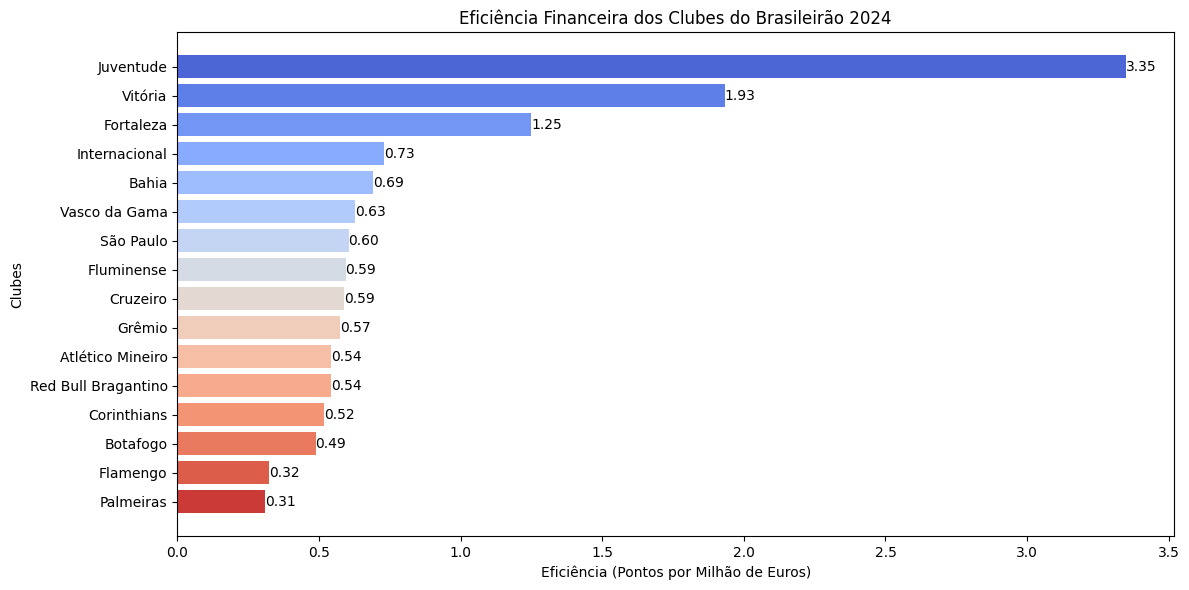

In [23]:
# Criar uma paleta de cores baseada na eficiência
cores = sns.color_palette("coolwarm", len(df))

# Gerar o gráfico com cores variadas
plt.figure(figsize=(12, 6))
bars = plt.barh(df['team'], df['eficiencia'], color=cores)
plt.barh(df['team'], df['eficiencia'], color=cores)
plt.xlabel('Eficiência (Pontos por Milhão de Euros)')
plt.ylabel('Clubes')
plt.title('Eficiência Financeira dos Clubes do Brasileirão 2024')

# Adicionar anotações em cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}', va='center')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
correlacao = df[['Pts', 'Valor de Mercado (€)']].corr()
print("Correlação entre Pontos e Valor de Mercado:")
print(correlacao)

Correlação entre Pontos e Valor de Mercado:
                           Pts  Valor de Mercado (€)
Pts                   1.000000              0.720351
Valor de Mercado (€)  0.720351              1.000000


Correlação positiva (0.721): Isso sugere que, em geral, clubes com maior valor de mercado tendem a conquistar mais pontos, mas essa relação não é perfeita.

Correlação moderada: Embora exista uma tendência positiva, outros fatores além do valor de mercado influenciam os pontos conquistados (como a gestão, técnico, planejamento e desempenho dos jogadores em campo).

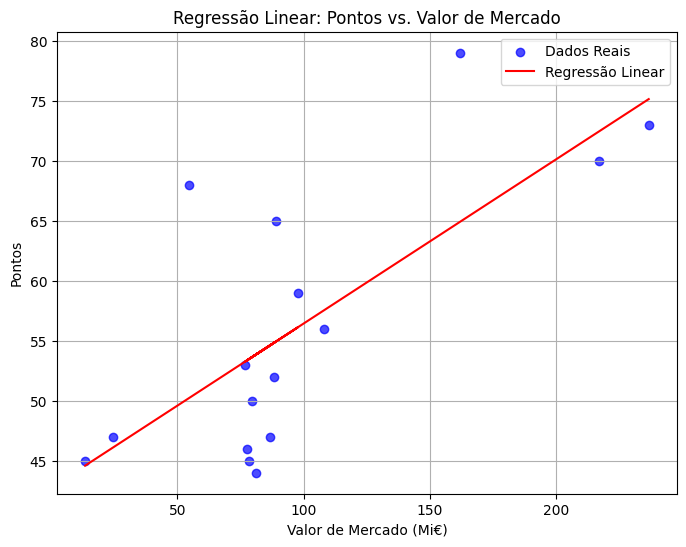

Coeficiente da Regressão: 0.14
Intercepto: 42.75


In [25]:
# Preparar os dados
X = df[['Valor de Mercado (€)']].values
y = df['Pts'].values

# Ajustar o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

# Fazer previsões
y_pred = modelo.predict(X)

# Plotar os resultados
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', alpha=0.7, label='Dados Reais')
plt.plot(X, y_pred, color='red', label='Regressão Linear')
plt.title('Regressão Linear: Pontos vs. Valor de Mercado')
plt.xlabel('Valor de Mercado (Mi€)')
plt.ylabel('Pontos')
plt.legend()
plt.grid(True)
plt.show()

print(f"Coeficiente da Regressão: {modelo.coef_[0]:.2f}")
print(f"Intercepto: {modelo.intercept_:.2f}")

In [26]:
r2 = modelo.score(X, y)
print(f"R²: {r2:.2f}")

R²: 0.52


O valor de R² = 0.52 indica que o modelo de regressão linear explica 52% da variação nos pontos dos clubes com base no valor de mercado. Isso sugere que o valor de mercado tem alguma influência no desempenho dos clubes, mas 48% da variação nos pontos é explicada por outros fatores.

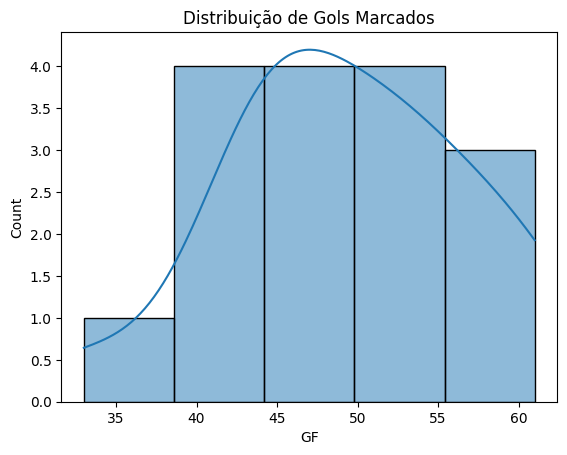

In [27]:
sns.histplot(df['GF'], kde=True)
plt.title('Distribuição de Gols Marcados')
plt.show()


- O gráfico mostra a distribuição de gols marcados (GF) em formato de histograma, com uma curva KDE (Kernel Density Estimate) sobreposta.
- A distribuição parece ser simétrica, com os gols marcados concentrados em torno de um intervalo central (aproximadamente entre 45 e 55 gols).
- Esse padrão sugere que a maioria dos times marca uma quantidade moderada de gols, sem muitos extremos de times que marquem poucos ou muitos gols.

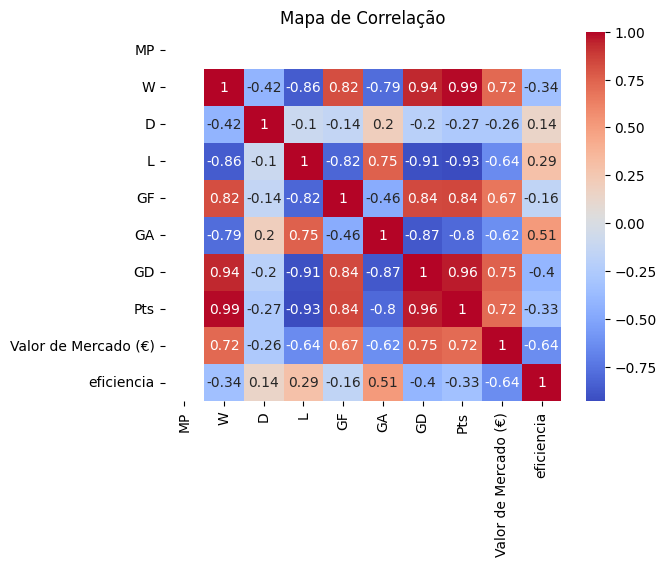

In [29]:
# Calculate correlation only for numeric columns
correlation = df.select_dtypes(include=np.number).corr()

# Plot the heatmap using seaborn
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação')
plt.show()


Análise de Variáveis-Chave:
- Vitórias (W)
  - Correlação positiva muito alta com:
    - Saldo de Gols (GD): 0.94
    - Pontos (Pts): 0.99
    - Gols Marcados (GF): 0.82
  -Faz sentido, já que times que vencem mais tendem a ter mais gols e saldo positivo.

- Gols Marcados (GF)

  - Alta correlação com:
    - Vitórias (W): 0.82
    - Saldo de Gols (GD): 0.88
  - Menor correlação com:
    - Eficiência: 0.29
  - Sugere que marcar gols ajuda no desempenho geral, mas a eficiência envolve outros fatores.

- Derrotas (L)

  - Correlação negativa forte com:
    - Pontos (Pts): -0.93
    - Vitórias (W): -0.86
    - Saldo de Gols (GD): -0.79
  - Mostra que mais derrotas estão fortemente associadas a um desempenho geral ruim.

- Eficiência

  - Alta correlação com:
    - Pontos (Pts): 0.62
  - Baixa ou moderada correlação com outras variáveis, indicando que a eficiência combina múltiplos fatores além de gols e vitórias

In [34]:
from sklearn.preprocessing import StandardScaler
# Padronizar os dados para clusterização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df[['GF', 'GA', 'Poss_']])

# Definir e ajustar o modelo K-Means
kmeans = KMeans(n_clusters=4, init='random', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

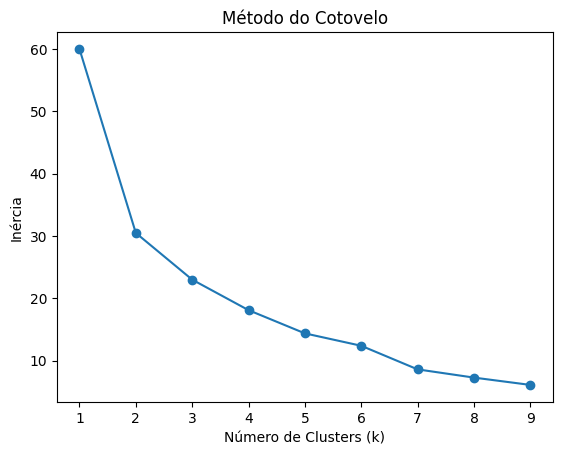

In [35]:
#Avaliar o Número de Clusters
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

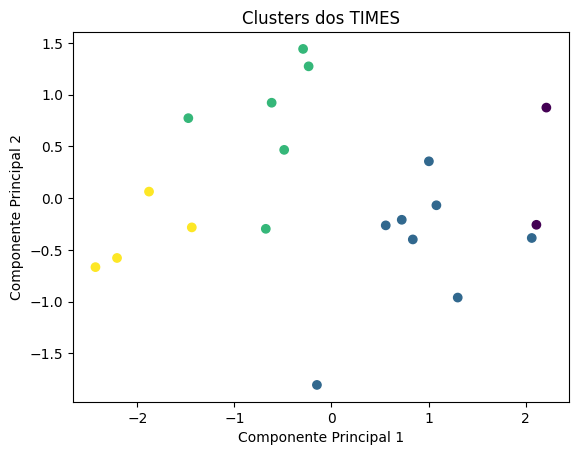

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters dos TIMES')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [38]:
# Selecionar apenas as colunas numéricas para calcular a correlação
numeric_columns = merged_df.select_dtypes(include=np.number).columns
correlation_matrix = merged_df[numeric_columns].corr()
# Remover colunas e linhas com valores NaN
cleaned_correlation_matrix = correlation_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')

# Exibir a matriz de correlação
print(cleaned_correlation_matrix)

                                W         D         L        GF        GA  \
W                        1.000000 -0.360947 -0.911454  0.886279 -0.779556   
D                       -0.360947  1.000000 -0.054682 -0.133885  0.181363   
L                       -0.911454 -0.054682  1.000000 -0.889861  0.754650   
GF                       0.886279 -0.133885 -0.889861  1.000000 -0.532827   
GA                      -0.779556  0.181363  0.754650 -0.532827  1.000000   
GD                       0.952868 -0.179344 -0.941104  0.882133 -0.868596   
Pts                      0.991041 -0.233163 -0.958233  0.904978 -0.786895   
players_used_           -0.068740 -0.012208  0.078985 -0.050566  0.109684   
Age_                     0.037171 -0.014789 -0.033274 -0.081255  0.014881   
Poss_                    0.484908 -0.125164 -0.463968  0.428541 -0.445807   
Performance_Gls          0.857927 -0.090882 -0.878476  0.996391 -0.495109   
Performance_Ast          0.745320 -0.183162 -0.717201  0.818908 -0.432560   

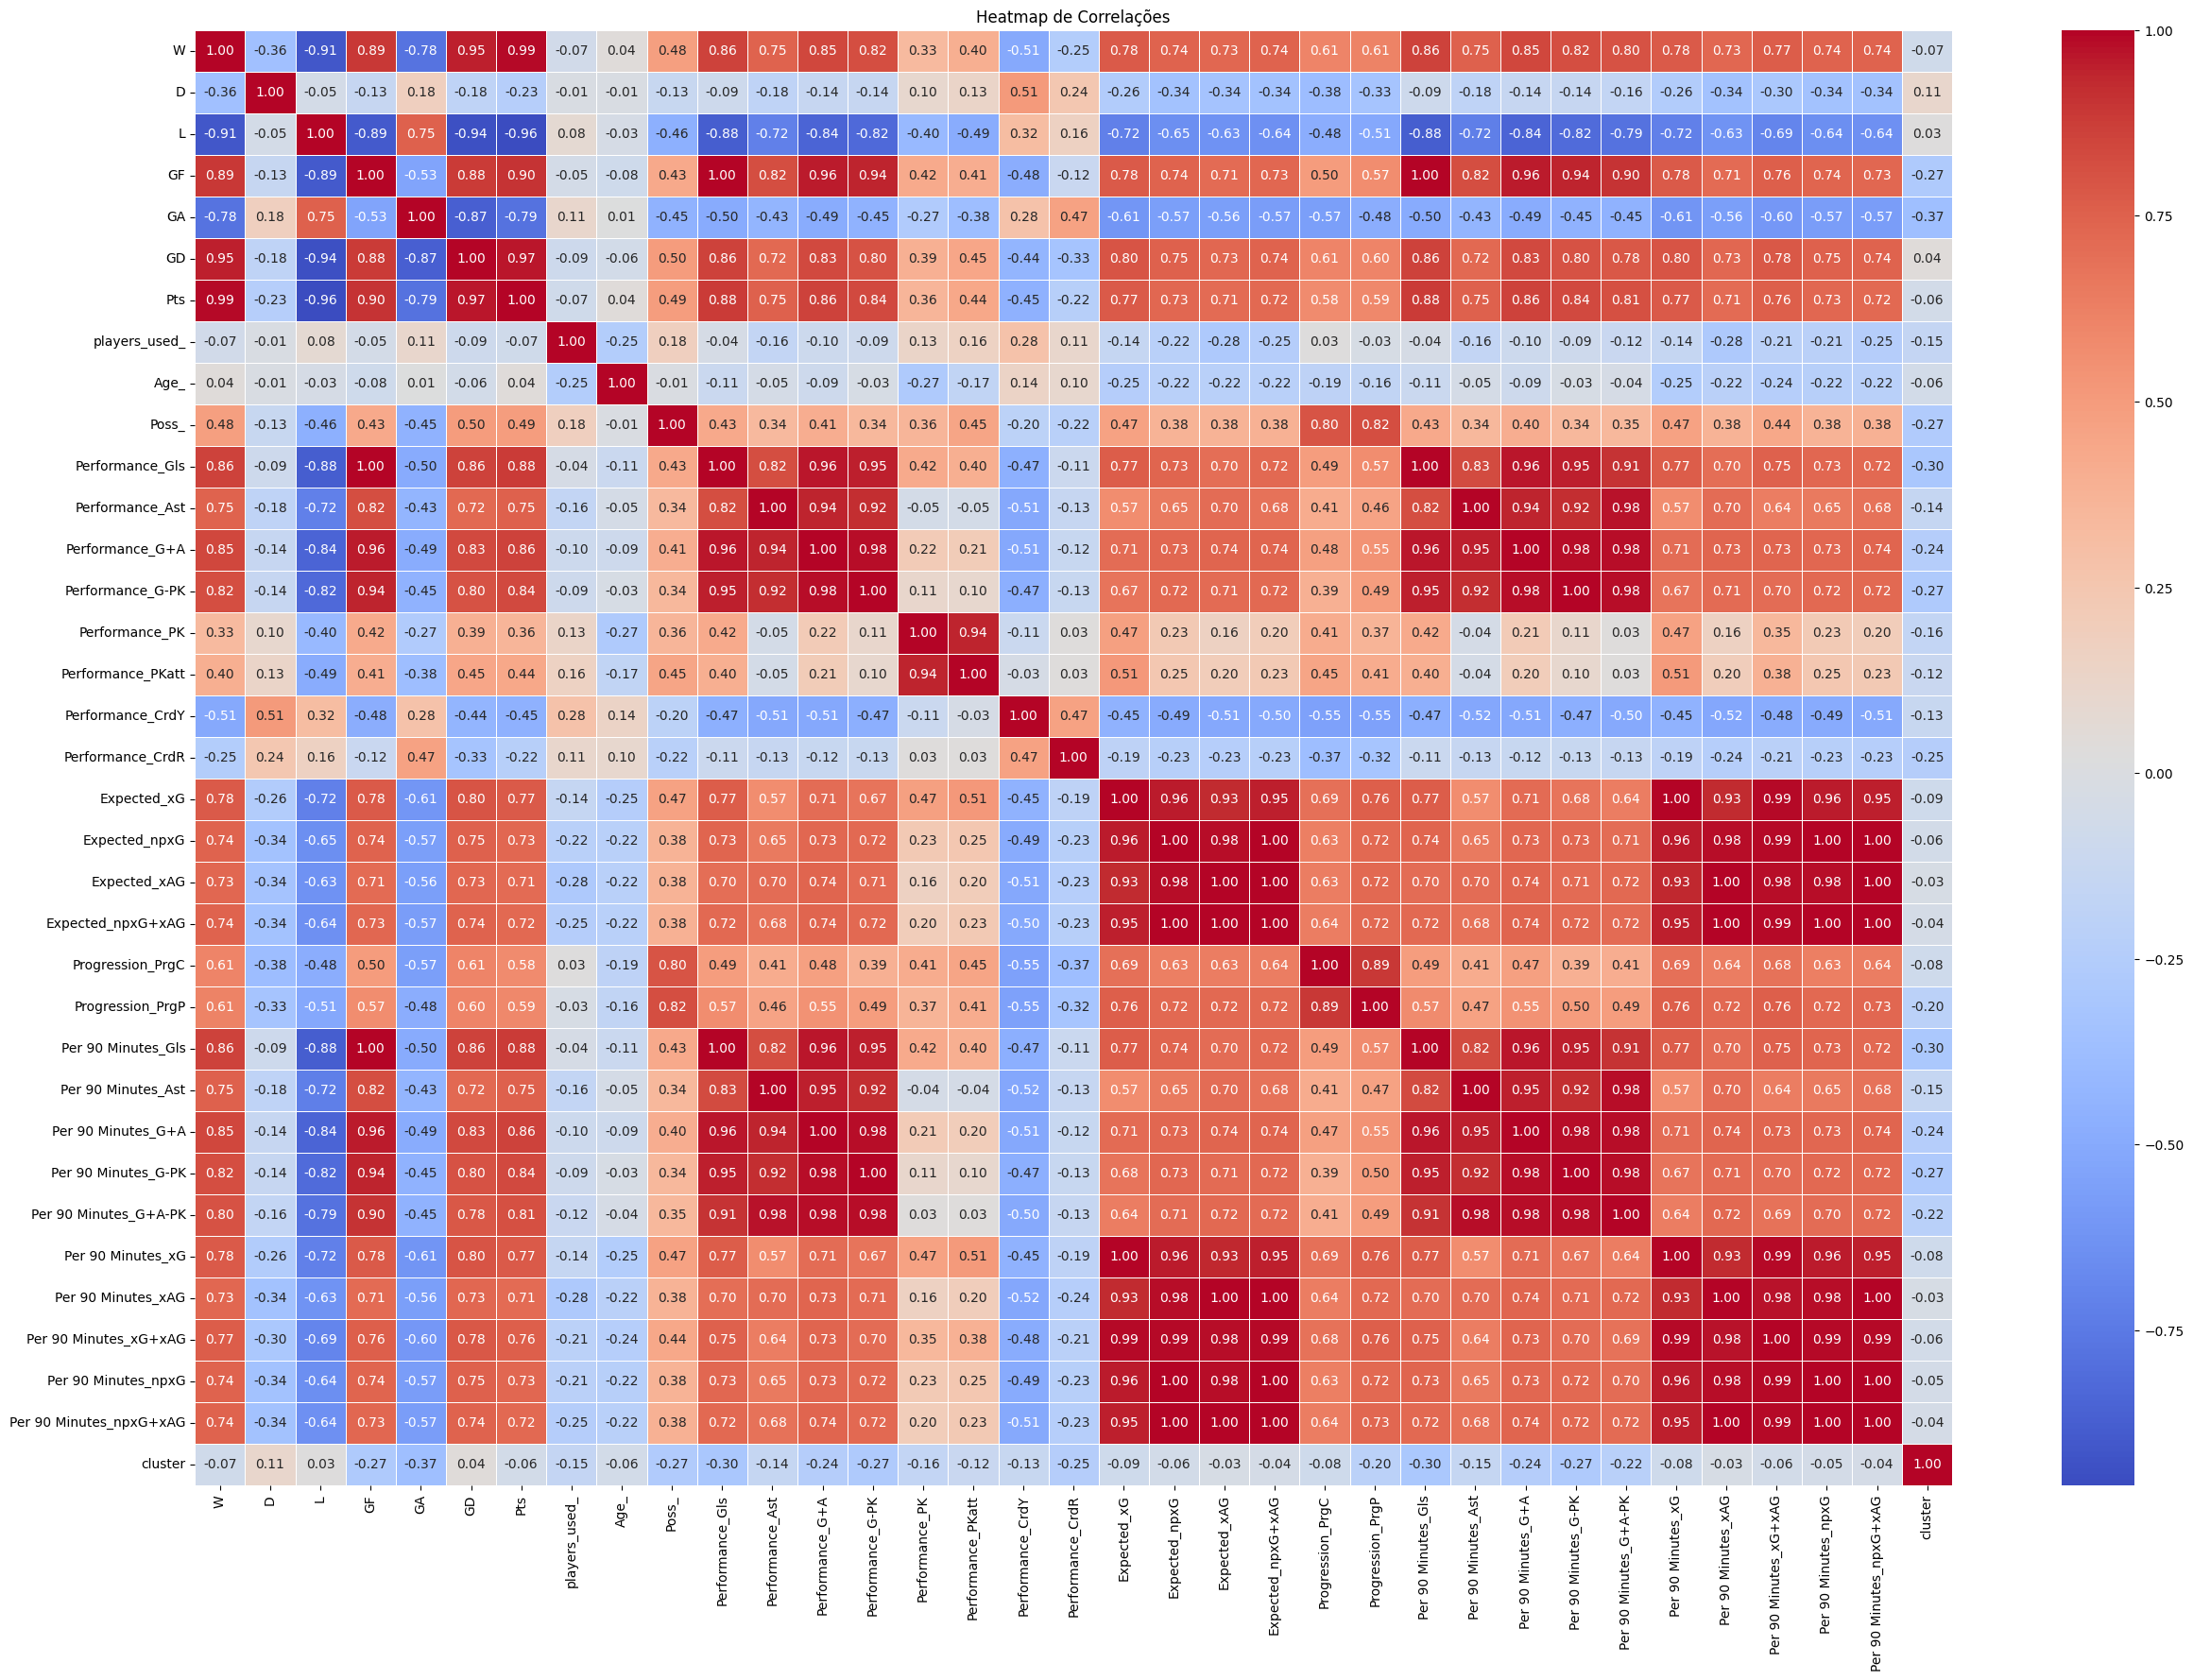

In [39]:
plt.figure(figsize=(30, 20))  # Define o tamanho da figura
sns.heatmap(cleaned_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap de Correlações')
plt.show()